In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/SIH

/content/drive/MyDrive/SIH


In [4]:
!pip install fastseg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.6 MB/s eta 0:00:00


In [5]:
import torch
from PIL import Image
from IPython.display import display
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from fastseg import MobileV3Large
from fastseg.image import colorize, blend

print(torch.__version__)

2.4.0+cu121


In [6]:
model = MobileV3Large.from_pretrained().eval()

Loading pretrained model mobilev3large-lraspp with F=128...


Downloading: "https://github.com/ekzhang/fastseg/releases/download/v0.1-weights/mobilev3large-lraspp-f128-9cbabfde.pt" to /root/.cache/torch/hub/checkpoints/mobilev3large-lraspp-f128-9cbabfde.pt
100%|██████████| 25.3M/25.3M [00:00<00:00, 57.1MB/s]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


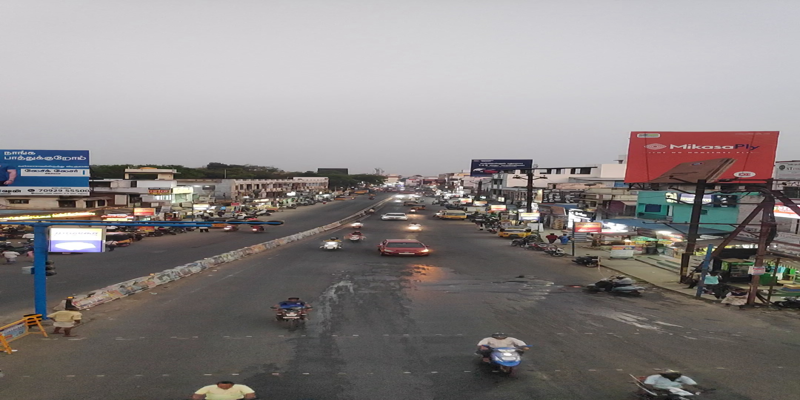

In [20]:
img = Image.open('/content/drive/MyDrive/SIH/Images/01/17.jpg')
display(img.resize((800, 400)))

In [21]:
labels = model.predict_one(img)
print('Shape:', labels.shape)
print(labels)

Shape: (1920, 1080)
[[10 10 10 ... 15 16 16]
 [10 10 10 ... 15 16 16]
 [10 10 10 ... 15 15 15]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


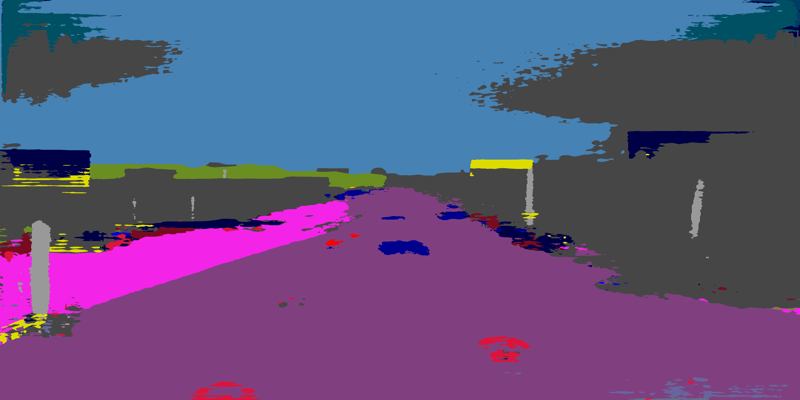

In [22]:
colorized = colorize(labels)
display(colorized.resize((800, 400)))

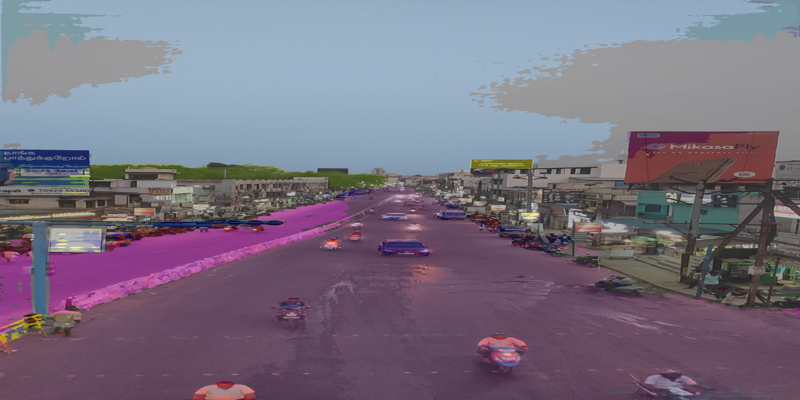

In [23]:
composited = blend(img, colorized)
display(composited.resize((800, 400)))

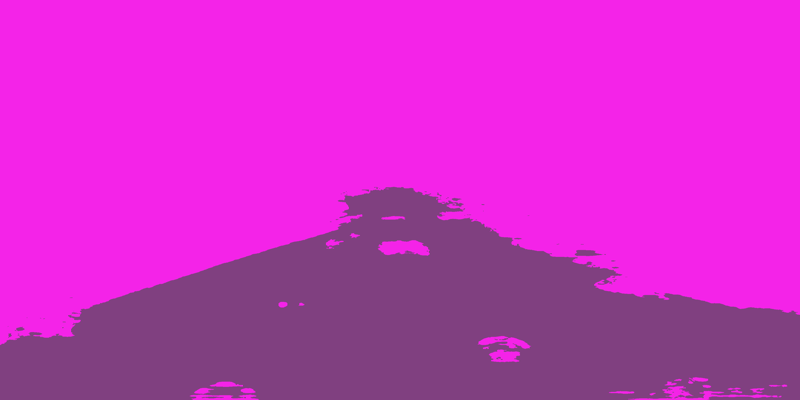

In [24]:
def remove_small_segments(mask, min_area_threshold):
    _, labels, stats, _ = cv.connectedComponentsWithStats(mask.astype(np.uint8))

    filtered_mask = np.zeros_like(mask)
    for label, stat in enumerate(stats[1:], start=1):
        if stat[4] >= min_area_threshold:
            filtered_mask[labels == label] = 1

    return filtered_mask

filtered_mask = remove_small_segments(labels, min_area_threshold=50)

colorized = colorize(filtered_mask)
display(colorized.resize((800, 400)))

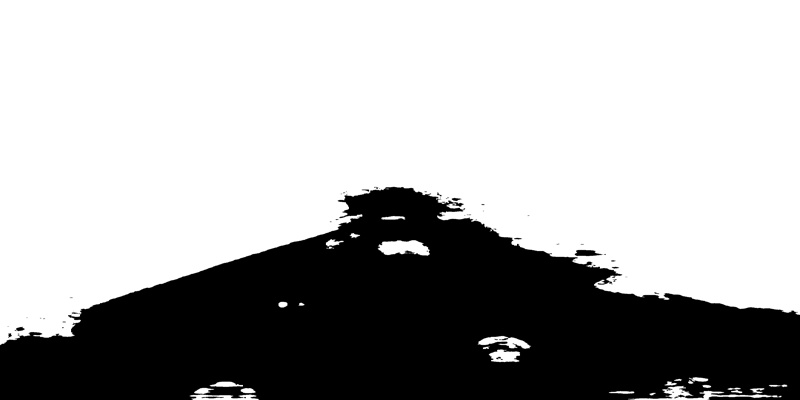

In [25]:
threshold_value = 0.5
binary_mask = np.where(filtered_mask > threshold_value, 1, 0)
grayscale_mask = binary_mask.astype(np.uint8) * 255

image = Image.fromarray(grayscale_mask)
display(image.resize((800, 400)))

In [26]:
kernel = np.ones((5, 5), np.uint8)
eroded_array = cv.erode(grayscale_mask, kernel, iterations=3)

image = Image.fromarray(eroded_array)
# display(image.resize((800, 400)))

In [27]:
def road_points(mask, threshold=50):
  top = None
  left = None
  right = None

  # top
  for y in range(mask.shape[0]):
    for x in range(mask.shape[1] - 1, -1, -1):
        if mask[y, x] < threshold:
          if(y <= mask.shape[0]/7):
            continue
          else:
            top = (x, y)
          break
    if top is not None:
        break

  # right
  for x in range(mask.shape[1] - 1, -1, -1):
    for y in range(mask.shape[0]):
      if mask[y, x] < threshold:
        if(y >= (mask.shape[0]*9)/10):
          right = (mask.shape[1], int((mask.shape[0]*9)/10))
        elif(y <= mask.shape[0]/1.7):
          continue
        else:
          right = (x, y)
        break
    if right is not None:
        break

  # left
  for x in range(mask.shape[1]):
    for y in range(mask.shape[0] - 1, -1, -1):
        if mask[y, x] < threshold:
            if(y >= (mask.shape[0]*9)/10):
              continue
            elif(y <= mask.shape[0]/1.7):
              left = (0, int((mask.shape[1]*9)/10))
            else:
              left = (x, y)
            break
    if left is not None:
        break

  if left is None:
    left = (0, int((mask.shape[1]*9)/10))

  if top is None:
    top = (int(mask.shape[1]/2), int(mask.shape[0]/2))

  if right is None:
    right = (int(mask.shape[1]), int((mask.shape[0]*9)/10))

  return top, right, left

top, right, left = road_points(eroded_array)
print(top, right, left)

(538, 891) (1079, 1491) (0, 1727)


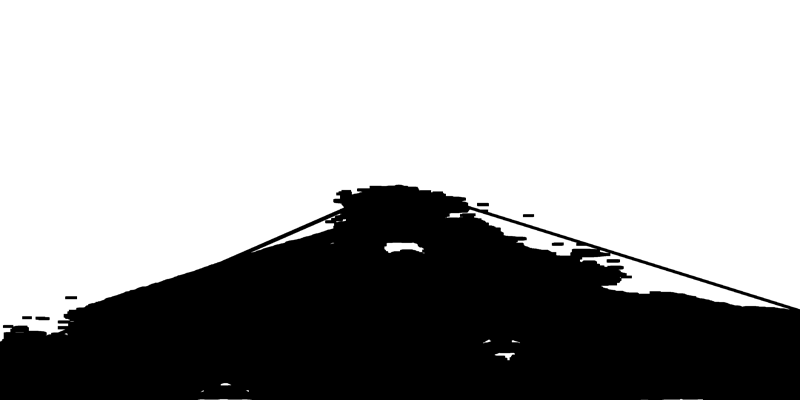

In [28]:
eroded_array = cv.line(eroded_array, (top[0], top[1]), (left[0], left[1]), (0, 255, 0), 10)
eroded_array = cv.line(eroded_array, (top[0], top[1]), (right[0], right[1]), (0, 255, 0), 10)

image = Image.fromarray(eroded_array)
display(image.resize((800, 400)))

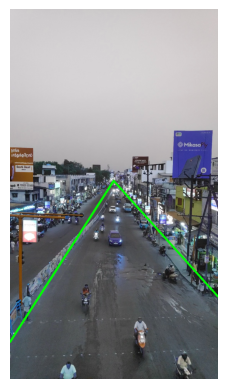

In [29]:
numpy_image = np.array(img)
real_image = cv.cvtColor(numpy_image, cv.COLOR_RGB2BGR)

real_image = cv.line(real_image, (top[0], top[1]), (left[0], left[1]), (0, 255, 0), 10)
real_image = cv.line(real_image, (top[0], top[1]), (right[0], right[1]), (0, 255, 0), 10)

plt.imshow(real_image)
plt.axis('off')
plt.show()

In [30]:
real_image.shape


(1920, 1080, 3)

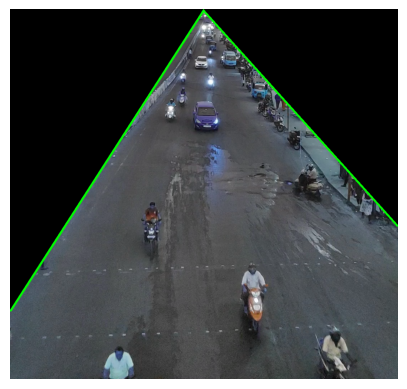

In [31]:
def crop_image(image, top, left, right):
  polygon = np.array([[0, image.shape[0]], [left[0], left[1]], [top[0], top[1]], [right[0], right[1]], [image.shape[1],image.shape[0]]],  np.int32)
  polygon = polygon.reshape((-1, 1, 2))

  mask = np.zeros(real_image.shape[:2], dtype=np.uint8)
  cv.fillPoly(mask, [polygon], 255)

  masked_image = cv.bitwise_and(real_image, real_image, mask=mask)

  x, y, w, h = cv.boundingRect(polygon)
  cropped_image = masked_image[y:y+h, x:x+w]

  return cropped_image

cropped_image = crop_image(real_image, top, left, right)

plt.imshow(cropped_image)
plt.axis('off')
plt.show()

In [32]:
# cv.imwrite('cropped_image.jpg', cropped_image)